# Session 04 - Clustering

Clustering (or cluster analysis) is the **task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups** (clusters).

Clustering is an **unsupervised** learning technique.

There are dozens of clustering algorithms, but they can be broadly classified into categories based on how they create clusters:

1. Connectivity-based clustering (hierarchical clustering)
1. Centroid-based clustering
1. Distribution-based clustering
1. Density-based clustering

## Table of Contents

1. Algorithms
    1. [K-Means Clustering](#K-Means-Clustering)
    1. [DBSCAN](#DBSCAN) (**D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise)
    1. [Agglomerative Heirarchical Clustering](#Agglomerative-Clustering)
    1. [Mean-Shift Clustering](#Mean-Shift-Clustering)
1. [Summary](#Summary)

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline

In [2]:
ENABLE_ASSERTIONS = True

## K-Means Clustering

K-Means is arguably one of the most popular (and simple) clustering algorithms. It is a **centroid based** algorithm. It creates `k` clusters in the following manner:

1. Randomly initialize k data points as _centroids_
1. Classify each data point as belonging to the nearest centroid
1. Recalculate _centroid_ for each cluster as the mean of all vectors belonging to that cluster
1. Repeat these steps for either `n` iterations, or until there is no change in centroids

In [3]:
def k_means(data, k, n_iter=10, random_state=np.random, show_progress=False):
    centroids = initialize_centroids(data, k, random_state)
    cluster_ids = classify(data, centroids)

    for _ in tqdm(range(n_iter)):
        centroids = calculate_centroids(data, cluster_ids)
        cluster_ids = classify(data, centroids)
        
    return cluster_ids, centroids

For initializing the random centroids, we sample k points from the dataset

In [4]:
def initialize_centroids(data, k, random_state):
    return data.sample(k, random_state=random_state)

We calculate the Euclidean distance of the entire dataset from each centroid, and then assign cluster ids based on the nearest centroid

In [5]:
def classify(data, centroids):
    centroid_distances = np.array([
        np.sum(np.power(data - centroid, 2), axis=1) 
        for _, centroid in centroids.iterrows()
    ])
    
    k, n = len(centroids), data.shape[0]

    # centroid_distances[i, j] is the distance to the ith centroid for the jth data point
    if ENABLE_ASSERTIONS: assert centroid_distances.shape == (k, n)

    cluster_ids = centroid_distances.argmin(axis=0)
    
    # Each data point is assigned to a cluster
    if ENABLE_ASSERTIONS: assert cluster_ids.shape == (n, )

    return cluster_ids

We determine new centroids by calculating the means of each cluster

In [6]:
def calculate_centroids(data, cluster_ids):
    return data.groupby(cluster_ids).mean()

One of the potential applications of k-means is **compressing images** by replacing the color map with representative cluster means. Thus an image with millions of pixel values can be compressed down to 8 or 16 color values, while retaining most of the structure of the original image.

In [7]:
img = imread("data/sunset.jpg")

In [8]:
img.shape

(539, 960, 3)

In [9]:
def img2df(img):
    r, g, b = [img[:, :, i].flatten() for i in range(3)]
    return pd.DataFrame({'R': r, 'G': g, 'B': b})

In [10]:
df = img2df(img)
df.head()

,B,G,R
0,145,93,130
1,145,93,130
2,145,93,130
3,145,93,130
4,145,93,130


In [11]:
k = 8
cluster_ids, centroids = k_means(df, k, random_state=42, show_progress=True)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [12]:
centroids = centroids.astype(np.uint8)
centroids

,B,G,R
0,159,193,242
1,140,91,120
2,151,148,199
3,91,45,59
4,107,80,119
5,145,117,157
6,42,20,30
7,119,67,89


In [13]:
new_df = centroids.iloc[cluster_ids]
new_df = new_df[['R', 'G', 'B']]
new_img = new_df.values.reshape((img.shape))

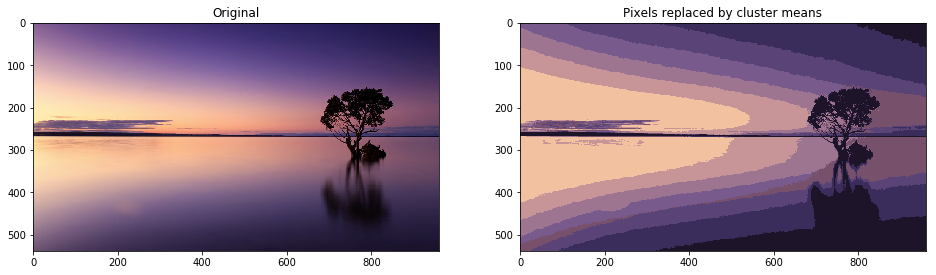

In [14]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.subplot(1, 2, 2)
plt.title("Pixels replaced by cluster means")
plt.imshow(new_img)

**Notes**

 *  A variant of K-Means is K-Medoids, which chooses data points from the sample as cluster centers (as opposed to K-means where the centers may not belong to the original dataset). 
 * A downside of this algorithm is that one needs to specify the number of clusters in advance.

## DBSCAN

DBSCAN is one of the most cited clustering algorithms. It is a **density** based clustering algorithm. It has two main concepts:

1. **Core point**: A data point that has at least `k` points within a radius $\epsilon$.
1. **Reachable**: A point is said to be _reachable_ from a core point if it is within its radius $\epsilon$.  

The algorithm works as follows:

1. Start with cluster number `c = 1`
1. Pick a random, unvisited point.
1. If it is not a core point, mark it as an outlier, and retry.
1. For all points reachable from this point, mark them as belonging to cluster `c`. Additionally, if they are also core points, repeat this step for each of them.
1. Once this yields no new points, increment c, and start again from step 2.

Note that points marked as outliers may later be reached from some other point.

In [15]:
from collections import defaultdict, deque

In [16]:
import datetime as dt

In [17]:
def fakelog(s):
    print("{}\t{}".format(dt.datetime.now().isoformat(), s))

In [18]:
UNPROCESSED = -1
NOISE = 0

def dbscan(data, eps, k, distance_func, random_state=np.random):
    """
    Arguments
    ---------
    data: pd.DataFrame
        A dataframe of dimensions n x m
    
    eps: float
        The radius for core points
    
    k: int
        Minimum number of points within radius to qualify as core point
        
    distance_func: x, y -> d
        A callable that takes two data points and returns the distance between them
    """
    data = data.copy()
    data.index = range(len(data.index))

    n = data.shape[0]

    clusters = np.array([UNPROCESSED] * n)

    unvisited = set(data.index)
    
    # Compute an n^2 matrix containing the distances between each pair of points
    distances = initialize_distances(data, distance_func)
    is_core_point = (distances <= eps).sum(axis=1) > k
    
    max_k = (distances <= eps).sum(axis=1).max()
    min_eps, max_aps = distances.min(), distances.max()
    
    if is_core_point.sum() == 0:
        raise ValueError(
            "Did not find any core points. " +
            "Try a lower value for k (current={}, max={}) ".format(k, max_k) +
            "or a higher value for eps (current={}, min={}, max={}).".format(eps, min_eps, max_aps)
        )

    print("Found {} core points".format(is_core_point.sum()))
    
    c = 1

    while True:
        unvisited_arr = np.array(list(unvisited))
        idx = random_state.choice(unvisited_arr, size=1)[0]
        retries = 0

        while not is_core_point[idx]:
            clusters[idx] = NOISE

            idx = random_state.choice(unvisited_arr, size=1)[0]

            retries += 1

            # Check if all remaining have been marked as noise
            if all(clusters[np.array(list(unvisited))] == NOISE):
                return clusters

        fakelog("Finding all points (directly/indirectly) for cluster {}".format(c))
        reachables = bfs(idx, unvisited, distances, is_core_point, eps)
        fakelog("Found {} points belonging to cluster {}".format(len(reachables), c))
        
        # Remove them from the unvisited set, so that they are not claimed by another cluster
        unvisited = unvisited - reachables

        # Mark them as belonging to cluster c
        clusters[list(reachables)] = c
        
        # Increment cluster ID
        c += 1

        fakelog("# Unvisited points: {}".format(len(unvisited)))
        
        # If all the remaining points are NOISE, or we have no more points left, we can return
        if len(unvisited) == 0 or all(clusters[np.array(list(unvisited))] == NOISE):
            return clusters

In [19]:
def l1_norm(x):
    return np.linalg.norm(x, 1, axis=1)

def l2_norm(x):
    return np.linalg.norm(x, 2, axis=1)

DISTANCE_METRIC_LOOKUP = {
    'euclidean': l2_norm,
    'manhattan': l1_norm
}

def initialize_distances(data, distance_func):
    n = data.shape[0]

    distances = np.zeros(shape=(n, n))
    func = DISTANCE_METRIC_LOOKUP[distance_func]
    for i in range(n):
        distances[i] = func(data.iloc[i] - data)
            
    return np.array(distances)

In [20]:
def bfs(i, unvisited, distances, is_core_point, eps):
    q = deque()
    visited = set()

    q.append(i)

    while q:
        p = q.popleft()
        visited.add(p)

        if not is_core_point[p]:
            continue

        reachables = set(np.asarray(distances[p] <= eps).nonzero()[0])
        q.extend((reachables & unvisited) - visited)

    return visited                

In [21]:
authors = pd.read_json("authors.jl", lines=True)

features = ["avg_rating", "num_ratings", "num_reviews"]

authors = authors.dropna(subset=features)
authors = authors.sample(2000, random_state=42)

authors.index = range(len(authors.index))

af = authors[features]

# Normalize columns
af = (af - af.min())/(af.max() - af.min())
af.head(3)

,avg_rating,num_ratings,num_reviews
0,0.796,0.005546,0.006685
1,0.828,0.000175,0.000733
2,0.848,0.001941,0.000702


In [22]:
clusters = dbscan(af, eps=0.02, k=320, distance_func='euclidean')

Found 373 core points
2019-04-15T23:22:36.362870	Finding all points (directly/indirectly) for cluster 1
2019-04-15T23:22:42.969860	Found 340 points belonging to cluster 1
2019-04-15T23:22:42.970181	# Unvisited points: 1660
2019-04-15T23:22:42.971069	Finding all points (directly/indirectly) for cluster 2
2019-04-15T23:22:43.041052	Found 376 points belonging to cluster 2
2019-04-15T23:22:43.041330	# Unvisited points: 1284
2019-04-15T23:22:43.226264	Finding all points (directly/indirectly) for cluster 3
2019-04-15T23:22:43.226599	Found 252 points belonging to cluster 3
2019-04-15T23:22:43.226758	# Unvisited points: 1032


In [23]:
centroids = af.groupby(clusters).mean()
centroids.head(5)

,avg_rating,num_ratings,num_reviews
0,0.771483,0.005735,9.642095e-03
1,0.000000,0.000000,1.795535e-07
2,0.786729,0.000696,1.792154e-03
3,0.747532,0.000824,2.284705e-03


In [24]:
groups = authors.groupby(clusters).groups

The group that was marked as outliers:

In [25]:
authors.iloc[groups[0].tolist()][features + ["name"]].head(4)

,avg_rating,num_ratings,num_reviews,name
1,4.14,115.0,24.0,Luna Merbruja
2,4.24,1277.0,23.0,Jule Styne
3,5.00,1.0,0.0,Gerard Di Trolio
4,3.17,6.0,0.0,Jacek Wijaczka


In [26]:
authors.iloc[groups[1].tolist()][features + ["name"]].head(5)

,avg_rating,num_ratings,num_reviews,name
8,0.0,0.0,0.0,Bohdan Bilan
11,0.0,0.0,0.0,Kathryn Pitkin
29,0.0,0.0,0.0,Stephanie A Jones
33,0.0,0.0,0.0,Jaroslav Dvořák
36,0.0,0.0,0.0,Birger P Priddat


In [27]:
authors.iloc[groups[2].tolist()][features + ["name"]].head(5)

,avg_rating,num_ratings,num_reviews,name
0,3.98,3649.0,219.0,Mark Divine
12,3.97,537.0,100.0,Amy MacDonald
16,3.87,3079.0,9.0,Aaron Tillman
17,4.00,1.0,0.0,楊斐萍
18,3.83,12.0,2.0,David M. Finkelstein


We note that the algorithm successfully detects a cluster with 0 `avg_rating`, `num_reviews` and `num_ratings`.

**Notes:**

 * The values for $\epsilon$ (radius) and `k` (minimum number of points) serve as parameters to the algorithm
 * For high-dimensional data, determining $\epsilon$ can be challenging
 * A salient feature is that it detects outliers instead of forcefully assigning them to a cluster

## Agglomerative Clustering

## Mean-Shift Clustering

# Summary

sklearn has a fantastic [summary image](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png) for different clustering algorithms on various toy datasets:

## ![Clustering Algorithms Comparison](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)